## Continuation of the Curve Analysis

Up to this point most of the codes have been approaches to get the twist characterization; ideally or most like a function of sorts: $\psi(r)$, according to what we would expect of a system like this. So, the work we have been doing as to the analysis of the data has been:
 - **Get the time average of the whole system (Protein):** This, considering the curve of the energy, $E = U+K$, and then with that select (*arbitrarly for the moment*) a stationary time $t_s$.
 - **Get each Molecule of the System (3 fragments):** For this as for right now, we get the fragments (`3*mol:3*mol+3`), which are the chains, and for a better representation we just filter the *backbone* atoms.
 - **Project the data to $(r, \varphi, z)$:** At first, I made the *end to end vector* of each molecule (which took a lot of time to figure out the "correct" and precise way), but that had 2 main troubles:
    - It was "arbitray", in the sense that the end atoms where not defined well for a "3 polymer" system (The polymer being the chain in this case, theres also a lot of trouble with this polymer assing)
    - Didnt capture the curvature, leading to bad representations in the projection of the dat (curves where there should be lines).
    
    So, my idea was then to get the projection of the atoms into the cylindrical space (trhough a simple line as the center of fibril, *to be improved*) and get the lines from this. It prove to be more effective to getting the lines well.

Nevertheless of this results, theres still improvements and flaw of this approach:
 - Stationary time select and more equilibrated data.
 - Its the backbone a reliable structural sources?
 - Near radius effects on the angle $\varphi$ plot.

So, for this, Im gonna ignore right now the first 3 issues, and asses the last one in the best way: Cutting the data!

### Setup of the Data

#### Initialization

In [2]:
import MDAnalysis as md
import matplotlib.pyplot as plt
import numpy as np
import time # For benchmarking

# Load data
tpr_file = "/Users/alejandro/Desktop/mddocs/processing-analysis/fullcol-0308/results-0808/md_1.tpr"
xtc_file = "/Users/alejandro/Desktop/mddocs/processing-analysis/fullcol-0308/results-0808/md_1_noPBC.xtc"

u = md.Universe(tpr_file, xtc_file)
u.trajectory[-1]
protein = u.select_atoms("protein")
backbone = protein.select_atoms("backbone")
xd, yd, zd = u.trajectory[-1].dimensions[0:3]/10

t_eq = 15000 # ps
# Time Data
ti = u.trajectory[0].time
tf = u.trajectory[-1].time
nt = len(u.trajectory)-1
deltat = (tf-ti)/nt
t = np.linspace(ti,tf,nt+1)
mask = (t >= t_eq)

#### Functions

In [3]:
def get_mean_coords_chain(chain, molecule, mask, group):
    # Get the Mean Coordinates of each Chain (3, N_atoms, 3), chain, natom, coords 
    mean_coords = None
    chains = protein.fragments[3*molecule:3*molecule + 3]
    chain = chains[chain].select_atoms(group)
    n = 0
    for ts in u.trajectory[mask]:
        coords = chain.positions / 10
        if mean_coords is None:
            mean_coords = coords.astype(float)
            n = 1
        else:
            n += 1
            mean_coords += (coords - mean_coords) / n
    return mean_coords

def get_mean_coords_mol(molecule, mask, group):
    # Get the Mean Coordinates of the molecule
    mean_coords = None
    chains = protein.fragments[3*molecule:3*molecule + 3]
    colmol = chains[0] + chains[1] + chains[2]
    colmol = colmol.select_atoms(group)
    for ts in u.trajectory[mask]:
        coords = colmol.positions / 10
        if mean_coords is None:
            mean_coords = coords.astype(float)
            n = 1
        else:
            n += 1
            mean_coords += (coords - mean_coords) / n
    return mean_coords

def centerline_fib(mask, group = "backbone"):
    # Get the low and top points of the center of the fibril - Line approximation
    fib_mean = None
    fib = protein.select_atoms(group)
    for ts in u.trajectory[mask]:
        coords = fib.positions / 10
        if fib_mean is None:
            fib_mean = coords.astype(float)
            n = 1
        else:
            n += 1
            fib_mean += (coords - fib_mean) / n

    x_cf = np.mean(fib_mean[:, 0])
    y_cf = np.mean(fib_mean[:, 1])
    z_cf = np.mean(fib_mean[:, 2])
    
    return x_cf, y_cf, z_cf

def mean_com(mask, group = "backbone"):
    fib_mean = None
    fib = protein.select_atoms(group)
    for ts in u.trajectory[mask]:
        com = fib.center_of_mass() / 10
        if fib_mean is None:
            fib_mean = com
            n = 1
        else:
            n += 1
            fib_mean += (com - fib_mean) / n
    
    return com[0], com[1], com[2]

def clean_phi(y, x):
    # Get the phi effectively getting rid of the jumps
    phi_p = np.atan2(y, x)
    phi_uw = np.unwrap(phi_p, discont=np.pi)
    return phi_uw

def cyl_proj(molecule, y_fun, x_fun):
    x = molecule[:, 0]
    y = molecule[:, 1]
    z = molecule[:, 2]

    r = np.sqrt((y - y_fun(z))**2 + (x - x_fun(z))**2)
    phi = clean_phi(y - y_fun(z), x - x_fun(z))
    return r, phi, z

### Center of the Fibril - Line Approximation

Get the center of the fibril. Given that the fibril should be already centered, and alligned with the z axis, then one can just assume that the center of the fibril will be a line passing through the z-axis, and the COM of the fibril, which should be the same as the geometrical center.

A function can be made to instead calculate the mean center of mass through the simulation.

In [4]:
# See function of the center of fibril, possible tunning/change in the approximation
# x_cfp, y_cfp, _ = centerline_fib(mask) # Geometrical Center
x_cfp, y_cfp, _ = mean_com(mask) # Center of Mass

# Line through z-axis
x_cf = lambda z: x_cfp
y_cf = lambda z: y_cfp

### One Molecule Visualization - Raw

Lets use the algorithm for the separated chains, but the one of the whole chains jointed should be better for running all the molecules of the system. For getting the projection and the first approximation is like this:
 - Computing:
    $$
    \varphi(z)=\arctan\left(\frac{y_\text{backbones}(z) - y_\text{center}(z)}{x_\text{backbones}(z) - x_\text{center}(z)} \right)
    $$

 - Geting a linear fit of the form:
    $$
    \varphi(z)=\tau z + \varphi_0
    $$

 - And getting the radius such as:
    $$
    r(z) = \sqrt{(y_\text{backbones}(z) - y_\text{center}(z))^2 + (x_\text{backbones}(z) - x_\text{center}(z))^2}
    $$


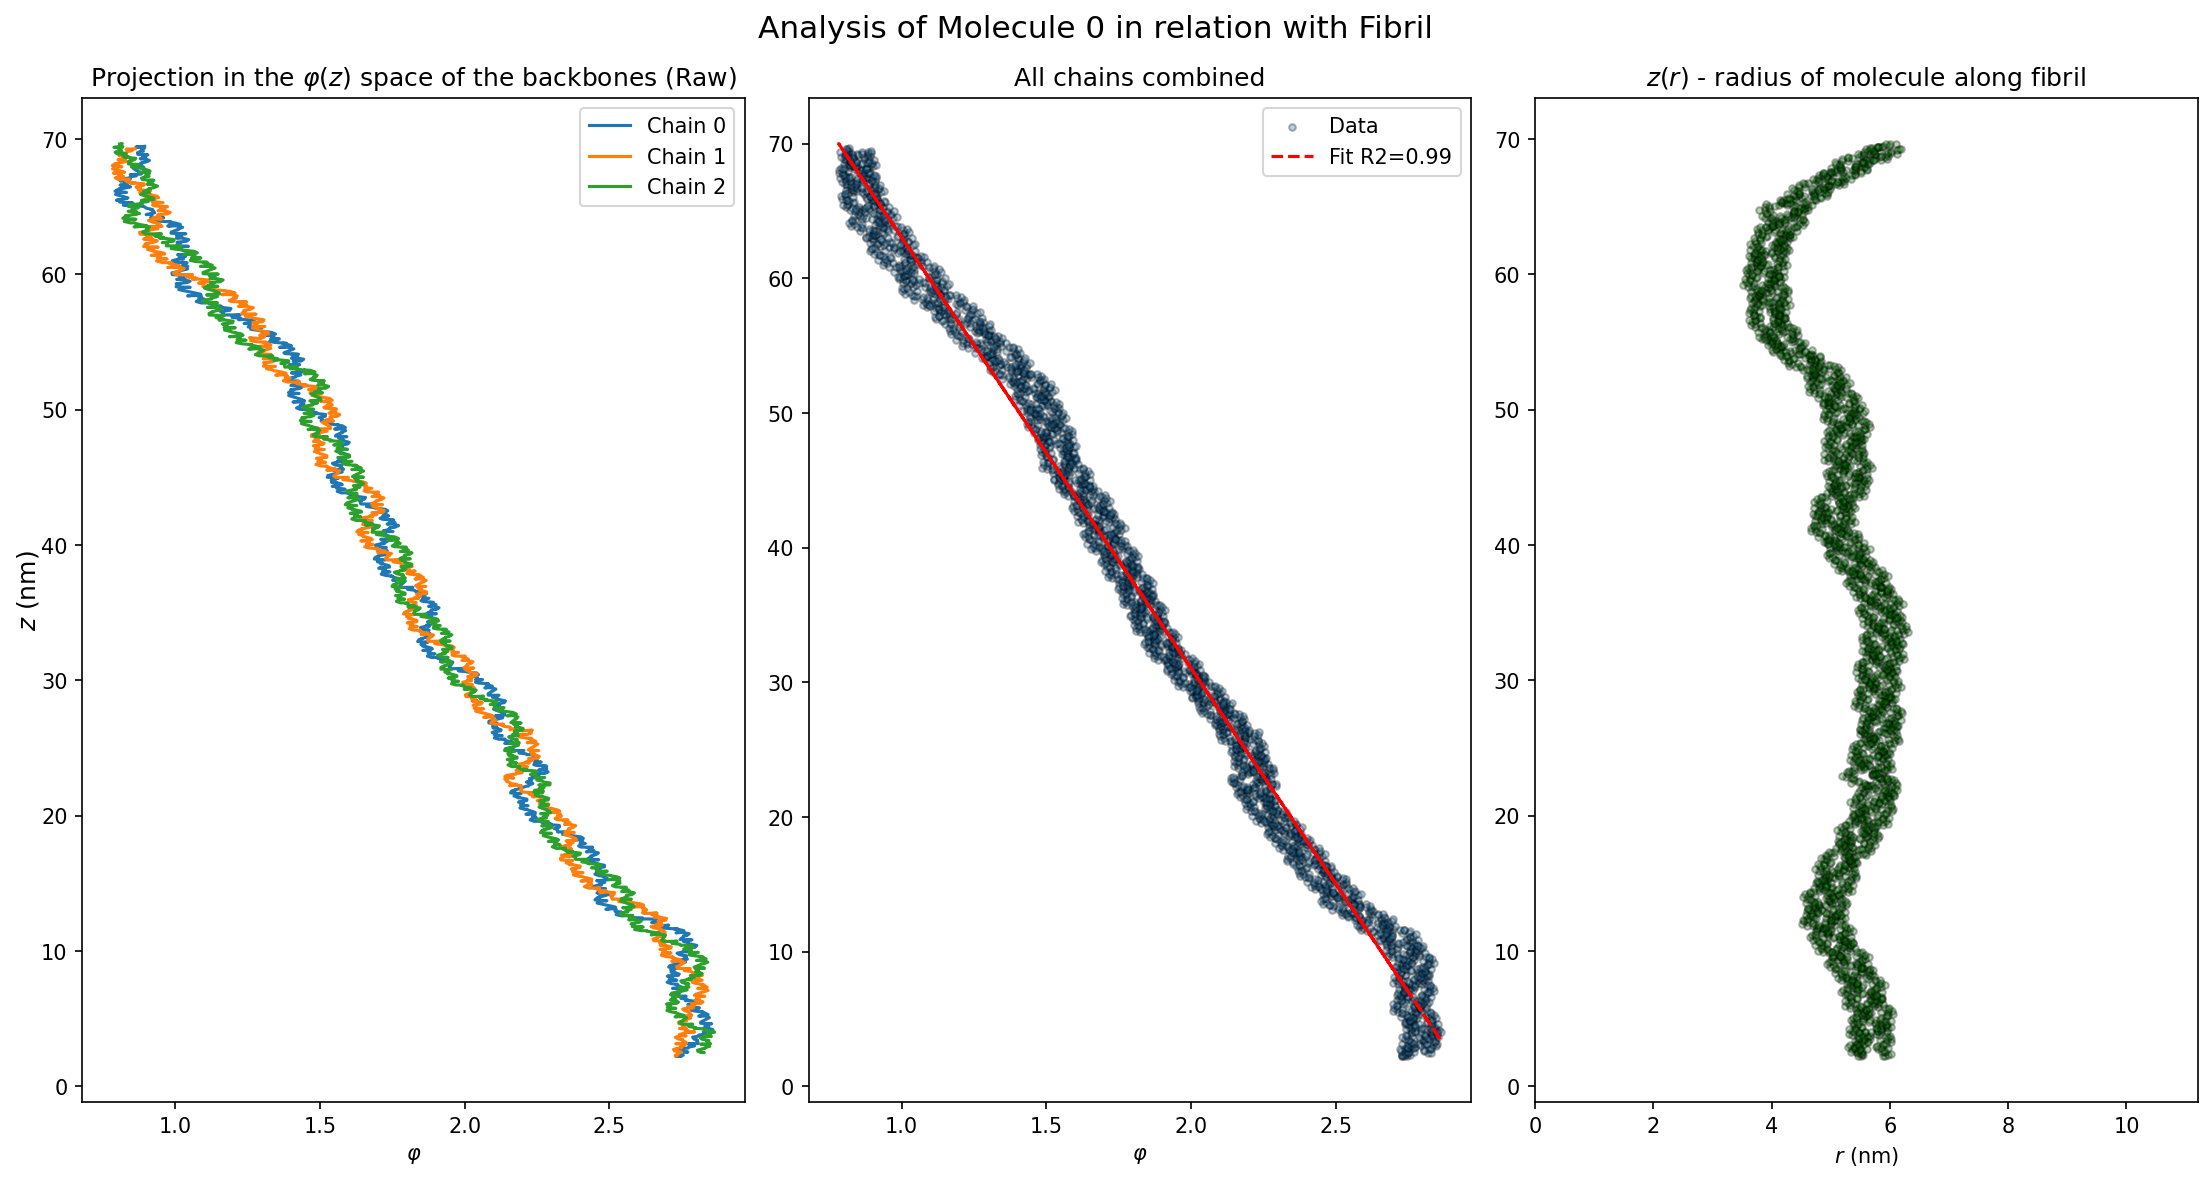

In [5]:
mol = 0

# Chain by Chain
# Get the Chain Means
strt_t = time.time() # Count time
chain_means = []
for i in range(3):
    chain_means.append(get_mean_coords_chain(i, mol, mask, "backbone"))
tot_t_3ch = time.time() - strt_t

# Plot Representation
fig, axs =  plt.subplots(1, 3, figsize=(15, 8), dpi=150)

radius_all = []
phi_all = []
z_all = []
# --- Left: original per-chain plot ---
for i in range(3):
    chain_coords = chain_means[i]
    z_chain = chain_coords[:, 2]
    phi_chain = clean_phi(chain_coords[:, 1] - y_cf(z_chain), chain_coords[:, 0] - x_cf(z_chain))
    r_chain = np.sqrt((chain_coords[:, 1] - y_cf(z_chain))**2 + (chain_coords[:, 0] - x_cf(z_chain))**2)
    radius_all.append(r_chain)
    phi_all.append(phi_chain)
    z_all.append(z_chain)
    axs[0].plot(phi_chain, z_chain, label=f"Chain {i}")
axs[0].set_title("Projection in the " + r"$\varphi(z)$" + " space of the backbones (Raw)")
axs[0].set_xlabel(r"$\varphi$")
axs[0].legend()

# --- Right: combined scatter of all chains ---
# Flatten Lists
radius_all = [element for sublist in radius_all for element in sublist]
phi_all = [element for sublist in phi_all for element in sublist]
z_all = [element for sublist in z_all for element in sublist]

axs[1].scatter(phi_all, z_all, s=10, edgecolor='k', alpha=0.3, label="Data")

# Make a linear fit
fit_res = np.polyfit(phi_all, z_all, 1, full=True)
m, b = fit_res[0]
# R2
SSE = fit_res[1][0]
diff = z_all - np.mean(z_all)
square_diff = diff ** 2
SST = np.sum(square_diff)
R2 = 1 - SSE/SST

fit = np.poly1d((m, b))
axs[1].plot(phi_all, fit(phi_all), linestyle='dashed', color='r', label=f"Fit R2={R2:.2f}")

axs[1].set_title("All chains combined")
axs[1].set_xlabel(r"$\varphi$")
# axs[1].set_ylabel(r"$z$ (nm)")
# axs[1].set_xlim(-np.pi, np.pi)
axs[1].legend()

# --- Right: radius vs z ---
axs[2].scatter(radius_all, z_all, s=10, color='g', edgecolor='k', alpha=0.3)
axs[2].set_xlabel(r"$r$ (nm)")
# axs[2].set_ylabel(r"$z$ (nm)")
axs[2].set_title(r"$z(r)$ - radius of molecule along fibril")
axs[2].set_xlim(0, np.sqrt(xd**2 + yd**2) / 2)

fig.supylabel(r"$z$ (nm)")
plt.suptitle(f"Analysis of Molecule {mol} in relation with Fibril", fontsize=15)
plt.tight_layout()
plt.show()


In [6]:
# Test difference of time with the whole molecule function
strt_t = time.time() # Count time
molecule_mean = get_mean_coords_mol(mol, mask, "backbone")
tot_t_whch = time.time() - strt_t

print("Secs of separated chains of molecule: " , tot_t_3ch, " s")
print("Secs of joint molecule: ", tot_t_whch, " s")

Secs of separated chains of molecule:  31.65541124343872  s
Secs of joint molecule:  5.018386125564575  s


The whole molecule seems more effective.

Seems to give a little better results, lets see the whole spectrum.

### Computation of $\tau(r)$ - End-Cut Molecules

For this, we will implement this cutting of the ends, and then represent the radius as the mean, $\langle r \rangle$, to see if theres better improvement in the results we get.

In [13]:
tot_mol = int((protein.fragindices[-1] + 1)/3)
tau = np.zeros(tot_mol)
r2s = np.zeros(tot_mol)
mean_rad = np.zeros(tot_mol)
err_rad = np.zeros((2, tot_mol)) # Shape for errobars


for mol in range(tot_mol):
    # Mean
    molecule_mean = get_mean_coords_mol(mol, mask, "backbone")
    
    # Cylindrical Coordinates
    rad, phi, z = cyl_proj(molecule_mean, y_cf, x_cf)

    # Tau
    fit_res = np.polyfit(phi, z, 1, full=True)
    tau[mol], b = fit_res[0]

    # R2
    SSE = fit_res[1][0]
    diff = z - np.mean(z)
    square_diff = diff ** 2
    SST = np.sum(square_diff)
    r2s[mol] = 1 - SSE/SST

    # Radius Data
    mean_rad[mol] = np.mean(rad)
    err_rad[:, mol] = mean_rad[mol] - min(rad), max(rad) - mean_rad[mol] # Error (Difference) Lower and Higher

Lets see if we can improve the data quality by filtering the "bad" fittings (one which have a jump). The most reasonable and straightforward method that comes to mind is by evaluating the linear fit (worse fit would correspond to jumps which cannot be correctly fitted).

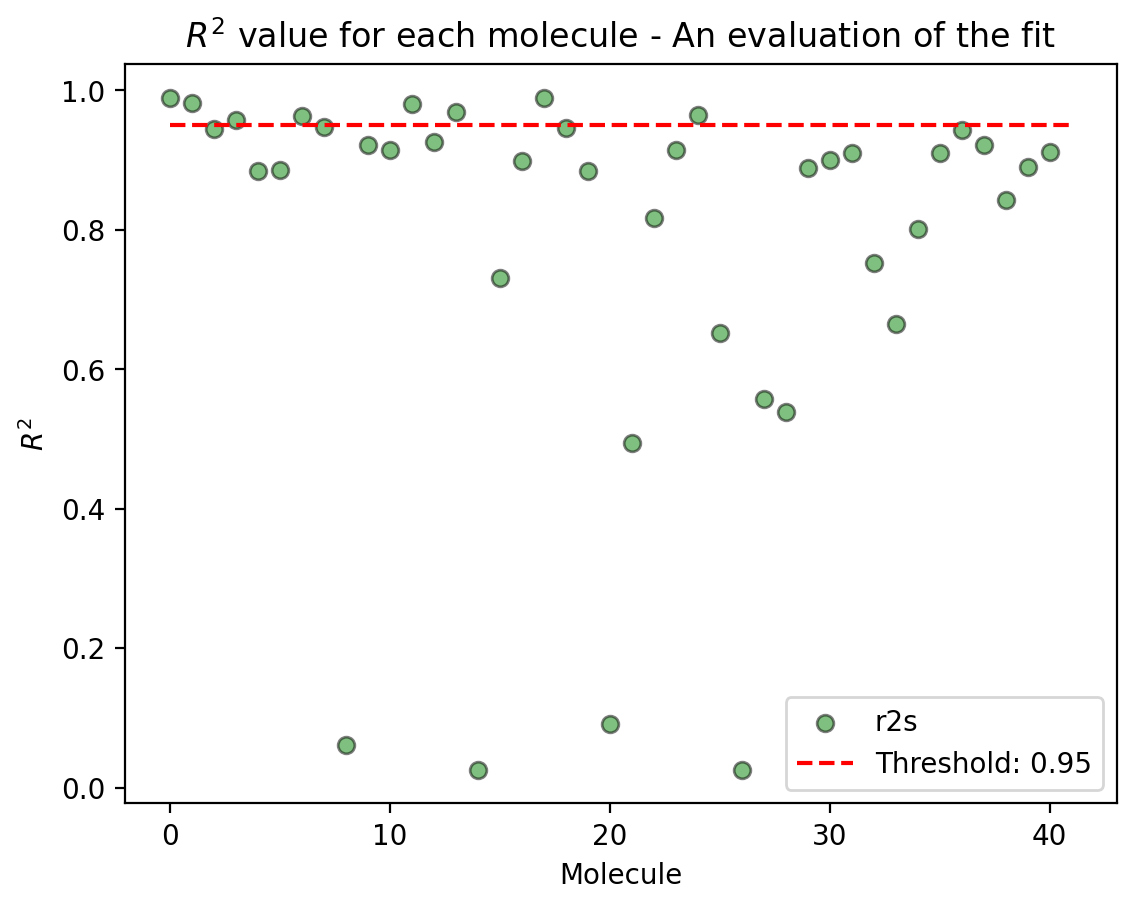

In [15]:
filt_r2 = 0.95

# Visualization of the Rsquared
plt.figure(dpi=200)
plt.scatter(np.arange(0, tot_mol), r2s, color='g', edgecolor='k', alpha=0.5, label='r2s')
plt.hlines(filt_r2, 0, tot_mol, color='r', linestyle='dashed', label=f'Threshold: {filt_r2}')
plt.xlabel(r'Molecule')
plt.ylabel(r'$R^2$')
plt.title(r"$R^2$ value for each molecule - An evaluation of the fit")
plt.legend()
plt.show()

# Filter data
maskr2 = (r2s >= filt_r2) 
tau_filt = tau[maskr2]
mean_rad_filt = mean_rad[maskr2]
err_rad_filt = err_rad[:,maskr2]

Lets see the result and the comparison evaluating the $R^2$ filtering.

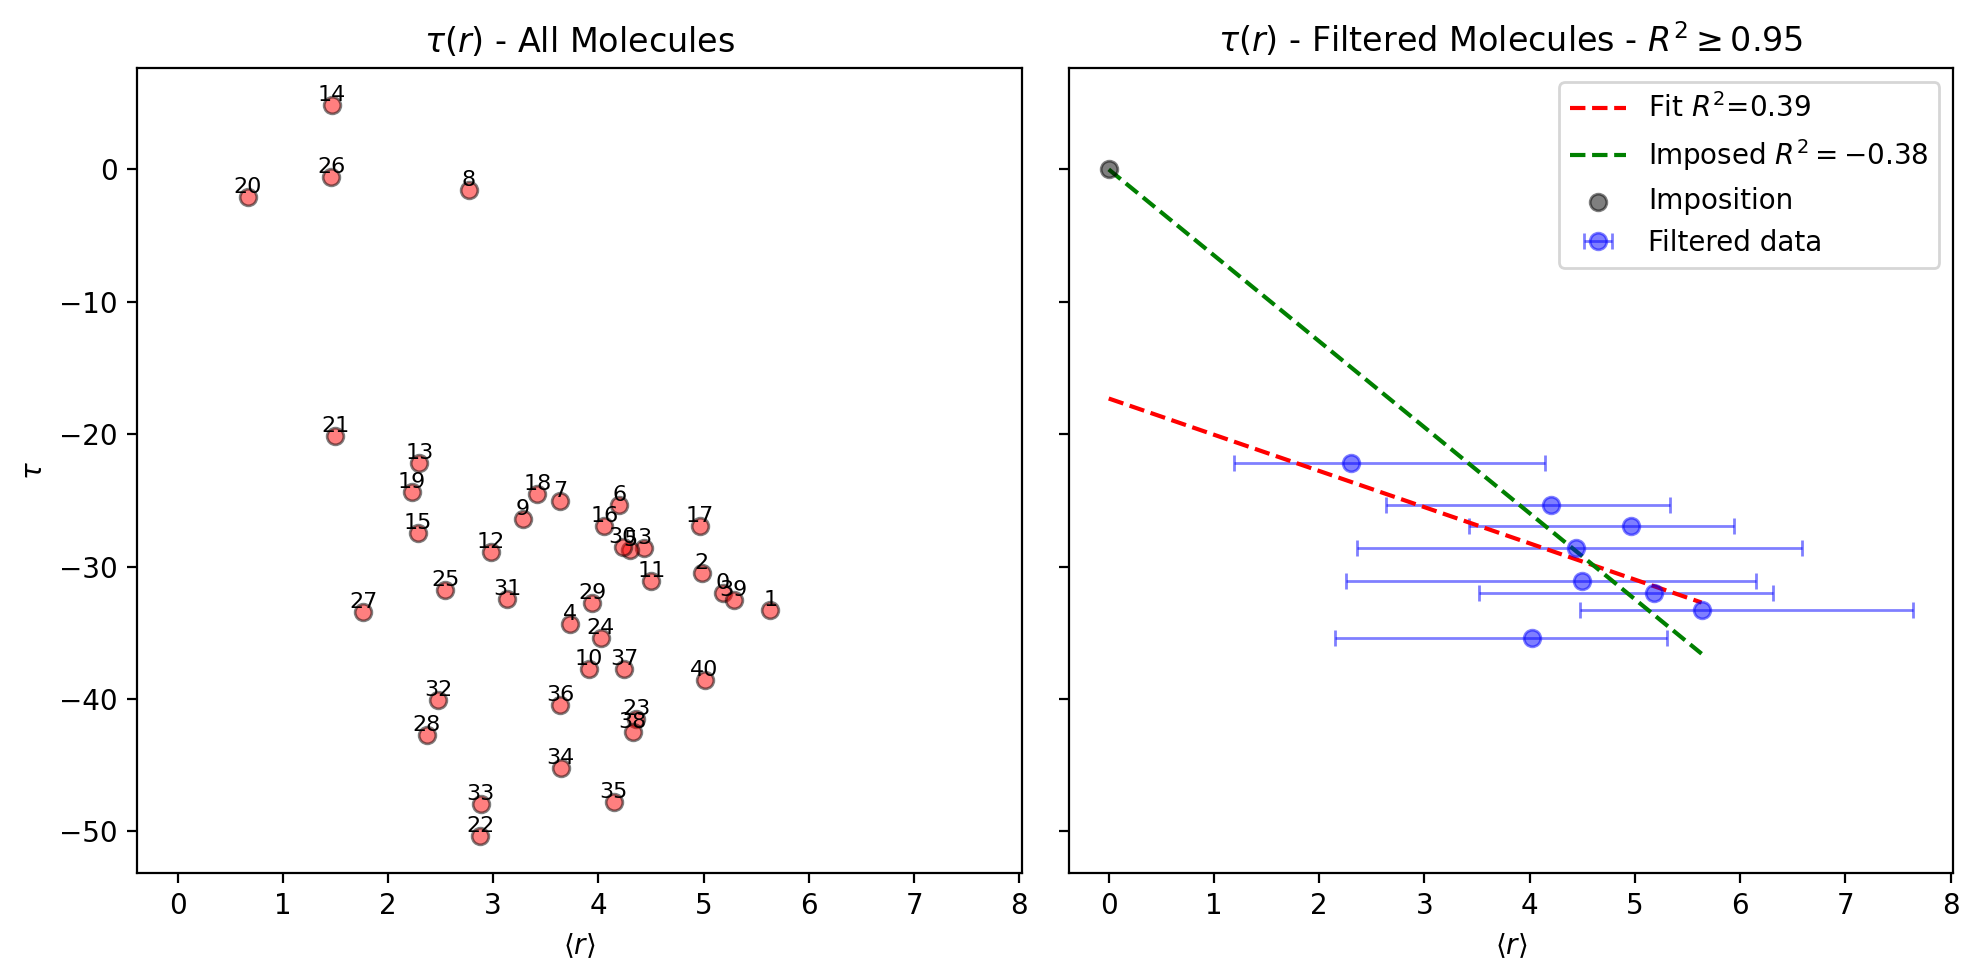

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), dpi=200, sharex=True, sharey=True)

# --- Left: original tau ---
axs[0].scatter(mean_rad, tau, color='r', edgecolor='k', alpha=0.5)

for i, (x, y) in enumerate(zip(mean_rad, tau)):
    axs[0].text(x, y, str(i), fontsize=8, ha='center', va='bottom')

axs[0].set_xlabel(r'$\langle r \rangle$')
axs[0].set_ylabel(r'$\tau$')
axs[0].set_title(r"$\tau(r)$ - All Molecules")

# --- Right: filtered tau ---
# axs[1].scatter(mean_rad_filt, tau_filt, color='b', edgecolor='k', alpha=0.5, label='Filtered data')
axs[1].errorbar(mean_rad_filt, tau_filt, xerr=err_rad_filt, fmt='o', color='b', mfc='b', mec='b', alpha=0.5, capsize=3, elinewidth=1, label='Filtered data')

# Fit and Evaluation
fit_res = np.polyfit(mean_rad_filt, tau_filt, 1, full=True)
m, b = fit_res[0]
# R2
SSE = fit_res[1][0]
diff = tau_filt - np.mean(tau_filt)
square_diff = diff ** 2
SST = np.sum(square_diff)
r2filt = 1 - SSE/SST

fit = np.poly1d((m, b))
r_plt = np.linspace(0, max(mean_rad_filt), 100)
axs[1].plot(r_plt, fit(r_plt), linestyle='dashed', color='r', label=rf"Fit $R^2$={r2filt:.2f}")

# --- Test: Impose (0,0) ---
# Use a more raw approach, from stack
r_fit_0 = mean_rad_filt[:,np.newaxis]
m0, _, _, _ = np.linalg.lstsq(r_fit_0, tau_filt)
tau_fit = m0 * mean_rad_filt
SSE = np.sum((tau_filt - tau_fit)**2)
SST = np.sum((tau_filt - np.mean(tau_filt))**2)
r2imp = 1 - SSE / SST


axs[1].plot(r_plt, m0*r_plt, linestyle='dashed', color='g', label=rf'Imposed $R^2={r2imp:.2f}$')
axs[1].scatter([0],[0], color='k', edgecolor='k', alpha=0.5, label='Imposition', zorder=3)

axs[1].set_xlabel(r'$\langle r \rangle$')
axs[1].set_title(rf"$\tau(r)$ - Filtered Molecules - $R^2 \geq${filt_r2}")
axs[1].legend()

plt.tight_layout()
plt.show()